In [ ]:
# pip install ninja
# !pip install -U flash-attn --no-build-isolation

In [ ]:
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info

model_path = "/DATA/Qwen22/qwen3b"

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
processor = AutoProcessor.from_pretrained(model_path)

In [ ]:
# # It's highly recommended to use `[decord]` feature for faster video loading.
# !pip install qwen-vl-utils[decord]

In [ ]:
import os
import math
import hashlib
import requests

from IPython.display import Markdown, display
import numpy as np
from PIL import Image
import decord
from decord import VideoReader, cpu


def download_video(url, dest_path):
    response = requests.get(url, stream=True)
    with open(dest_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8096):
            f.write(chunk)
    print(f"Video downloaded to {dest_path}")


def get_video_frames(video_path, num_frames=128, cache_dir='.cache'):
    os.makedirs(cache_dir, exist_ok=True)

    video_hash = hashlib.md5(video_path.encode('utf-8')).hexdigest()
    if video_path.startswith('http://') or video_path.startswith('https://'):
        video_file_path = os.path.join(cache_dir, f'{video_hash}.mp4')
        if not os.path.exists(video_file_path):
            download_video(video_path, video_file_path)
    else:
        video_file_path = video_path

    frames_cache_file = os.path.join(cache_dir, f'{video_hash}_{num_frames}_frames.npy')
    timestamps_cache_file = os.path.join(cache_dir, f'{video_hash}_{num_frames}_timestamps.npy')

    if os.path.exists(frames_cache_file) and os.path.exists(timestamps_cache_file):
        frames = np.load(frames_cache_file)
        timestamps = np.load(timestamps_cache_file)
        return video_file_path, frames, timestamps

    vr = VideoReader(video_file_path, ctx=cpu(0))
    total_frames = len(vr)

    indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)
    frames = vr.get_batch(indices).asnumpy()
    timestamps = np.array([vr.get_frame_timestamp(idx) for idx in indices])

    np.save(frames_cache_file, frames)
    np.save(timestamps_cache_file, timestamps)

    return video_file_path, frames, timestamps


def create_image_grid(images, num_columns=8):
    pil_images = [Image.fromarray(image) for image in images]
    num_rows = math.ceil(len(images) / num_columns)

    img_width, img_height = pil_images[0].size
    grid_width = num_columns * img_width
    grid_height = num_rows * img_height
    grid_image = Image.new('RGB', (grid_width, grid_height))

    for idx, image in enumerate(pil_images):
        row_idx = idx // num_columns
        col_idx = idx % num_columns
        position = (col_idx * img_width, row_idx * img_height)
        grid_image.paste(image, position)

    return grid_image

In [ ]:
def inference(video_path, prompt, max_new_tokens=2048, total_pixels=20480 * 28 * 28, min_pixels=16 * 28 * 28):
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": [
                {"type": "text", "text": prompt},
                {"video": video_path, "total_pixels": total_pixels, "min_pixels": min_pixels},
            ]
        },
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs, video_kwargs = process_vision_info([messages], return_video_kwargs=True)
    fps_inputs = video_kwargs['fps']
    print("video input:", video_inputs[0].shape)
    num_frames, _, resized_height, resized_width = video_inputs[0].shape
    print("num of video tokens:", int(num_frames / 2 * resized_height / 28 * resized_width / 28))
    inputs = processor(text=[text], images=image_inputs, videos=video_inputs, fps=fps_inputs, padding=True, return_tensors="pt")
    inputs = inputs.to('cuda')

    output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    return output_text[0]

In [ ]:
video_url = "/media/CAM2.avi"
prompt = "Localize a series of activity events in the video, output the start and end timestamp for each event, and describe each event with sentences. Provide the result in json format with 'mm:ss.ff' format for time depiction."

video_path, frames, timestamps = get_video_frames(video_url, num_frames=16)
# image_grid = create_image_grid(frames, num_columns=8)
# display(image_grid.resize((640, 640)))
# inference
response = inference(video_path, prompt,max_new_tokens=512,total_pixels=4096 * 28 * 28,  # reduced
    min_pixels=8 * 28 * 28  )
display(Markdown(response))

Unused or unrecognized kwargs: return_tensors, fps.


video input: torch.Size([532, 3, 56, 140])
num of video tokens: 2660


```json
[
	{"start_time": "00:00.00", "end_time": "00:15.80", "description": "A group of people are waiting at a train station platform"},
	{"start_time": "00:16.40", "end_time": "02:09.30", "description": "They are boarding a train as it pulls into the station"},
	{"start_time": "02:10.00", "end_time": "02:27.00", "description": "The train doors close and they all board"}
]
```

In [ ]:
# video_url = "/DATA/updated_code_batch_processing/test2_30fps.mp4"
# prompt = "Give the query: 'person walking', when does the described content occur in the video?"

# video_path, frames, timestamps = get_video_frames(video_url, num_frames=64)
# image_grid = create_image_grid(frames, num_columns=8)
# # display(image_grid.resize((640, 640)))

# # inference
# response = inference(video_path, prompt)
# display(Markdown(response))

In [ ]:
# pip install Markdown

In [ ]:
# pip install bs4

**00:00.00 - 00:15.80:**		A group of people are waiting at a train station platform

**00:16.40 - 02:09.30:**		They are boarding a train as it pulls into the station

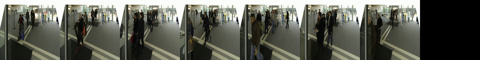

**02:10.00 - 02:27.00:**		The train doors close and they all board

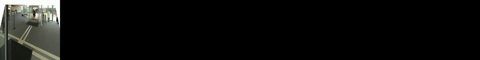

In [ ]:
import json
import markdown
from bs4 import BeautifulSoup
from datetime import datetime
import numpy as np
from IPython.display import display, Markdown

# --- Parse JSON from Markdown response ---
def parse_json(response):
    html = markdown.markdown(response, extensions=['fenced_code'])
    soup = BeautifulSoup(html, 'html.parser')
    json_text = soup.find('code').text
    data = json.loads(json_text)
    return data

# --- Normalize various time formats to mm:ss.ff ---
def normalize_time_str(time_str):
    try:
        seconds = float(time_str)
        minutes = int(seconds // 60)
        seconds_remainder = seconds % 60
        return f"{minutes:02}:{seconds_remainder:05.2f}"
    except ValueError:
        return time_str  # already in mm:ss.ff

# --- Convert mm:ss.ff to seconds ---
def time_to_seconds(time_str):
    time_str = normalize_time_str(time_str)
    time_obj = datetime.strptime(time_str, '%M:%S.%f')
    total_seconds = time_obj.minute * 60 + time_obj.second + time_obj.microsecond / 1_000_000
    return total_seconds

# --- Main Execution ---
data = parse_json(response)

for item in data:
    start_time_str = item["start_time"]
    end_time_str = item["end_time"]
    description = item["description"]

    # Normalize for display
    norm_start = normalize_time_str(start_time_str)
    norm_end = normalize_time_str(end_time_str)

    display(Markdown(f"**{norm_start} - {norm_end}:**\t\t" + description))

    # Convert to seconds for frame filtering
    start_time = time_to_seconds(start_time_str)
    end_time = time_to_seconds(end_time_str)

    # Collect relevant frames
    current_frames = []
    for frame, timestamp in zip(frames, timestamps):
        if timestamp[0] > start_time and timestamp[1] < end_time:
            current_frames.append(frame)

    current_frames = np.array(current_frames)

    if len(current_frames) > 0:
        current_image_grid = create_image_grid(current_frames, num_columns=8)
        display(current_image_grid.resize((480, (int(len(current_frames) / 8) + 1) * 60)))


In [ ]:
import json
import markdown
from bs4 import BeautifulSoup
from datetime import datetime


def parse_json(response):
    html = markdown.markdown(response, extensions=['fenced_code'])
    soup = BeautifulSoup(html, 'html.parser')
    json_text = soup.find('code').text

    data = json.loads(json_text)
    return data


def time_to_seconds(time_str):
    time_obj = datetime.strptime(time_str, '%M:%S.%f')
    total_seconds = time_obj.minute * 60 + time_obj.second + time_obj.microsecond / 1_000_000
    return total_seconds

data = parse_json(response)

for item in data:
    start_time = item["start_time"]
    end_time = item["end_time"]
    description = item["description"]

    display(Markdown(f"**{start_time} - {end_time}:**\t\t" + description))

    start_time = time_to_seconds(start_time)
    end_time = time_to_seconds(end_time)
    current_frames = []
    for frame, timestamp in zip(frames, timestamps):
        if timestamp[0] > start_time and timestamp[1] < end_time:
            current_frames.append(frame)

    current_frames = np.array(current_frames)
    current_image_grid = create_image_grid(current_frames, num_columns=8)

    display(current_image_grid.resize((480, (int(len(current_frames) / 8) + 1) * 60)))